In [1]:
import os
import numpy as np 
import pandas as pd 
import seaborn as sns
import networkx as nx
import matplotlib.pyplot as plt
from collections import Counter
from IPython.display import HTML
import plotly.graph_objects as go
from itertools import combinations
from IPython.display import IFrame
from itertools import combinations
from collections import defaultdict, Counter
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/retail-transaction-dataset/products.csv


In [2]:
df = pd.read_csv("/kaggle/input/retail-transaction-dataset/products.csv")
df['Timestamp'] = pd.to_datetime(df['Timestamp'])
df['Year'] = df['Timestamp'].dt.year
df['Month'] = df['Timestamp'].dt.month
df['Day'] = df['Timestamp'].dt.day
df['Weekday'] = df['Timestamp'].dt.day_name() 
df = df.drop(columns = "Timestamp")

In [3]:
customer_id = 'C340'
df_cust = df[df['CustomerID'] == customer_id].copy()
df_cust['ProductList'] = df_cust['Products'].apply(lambda x: [i.strip() for i in x.split(',')])

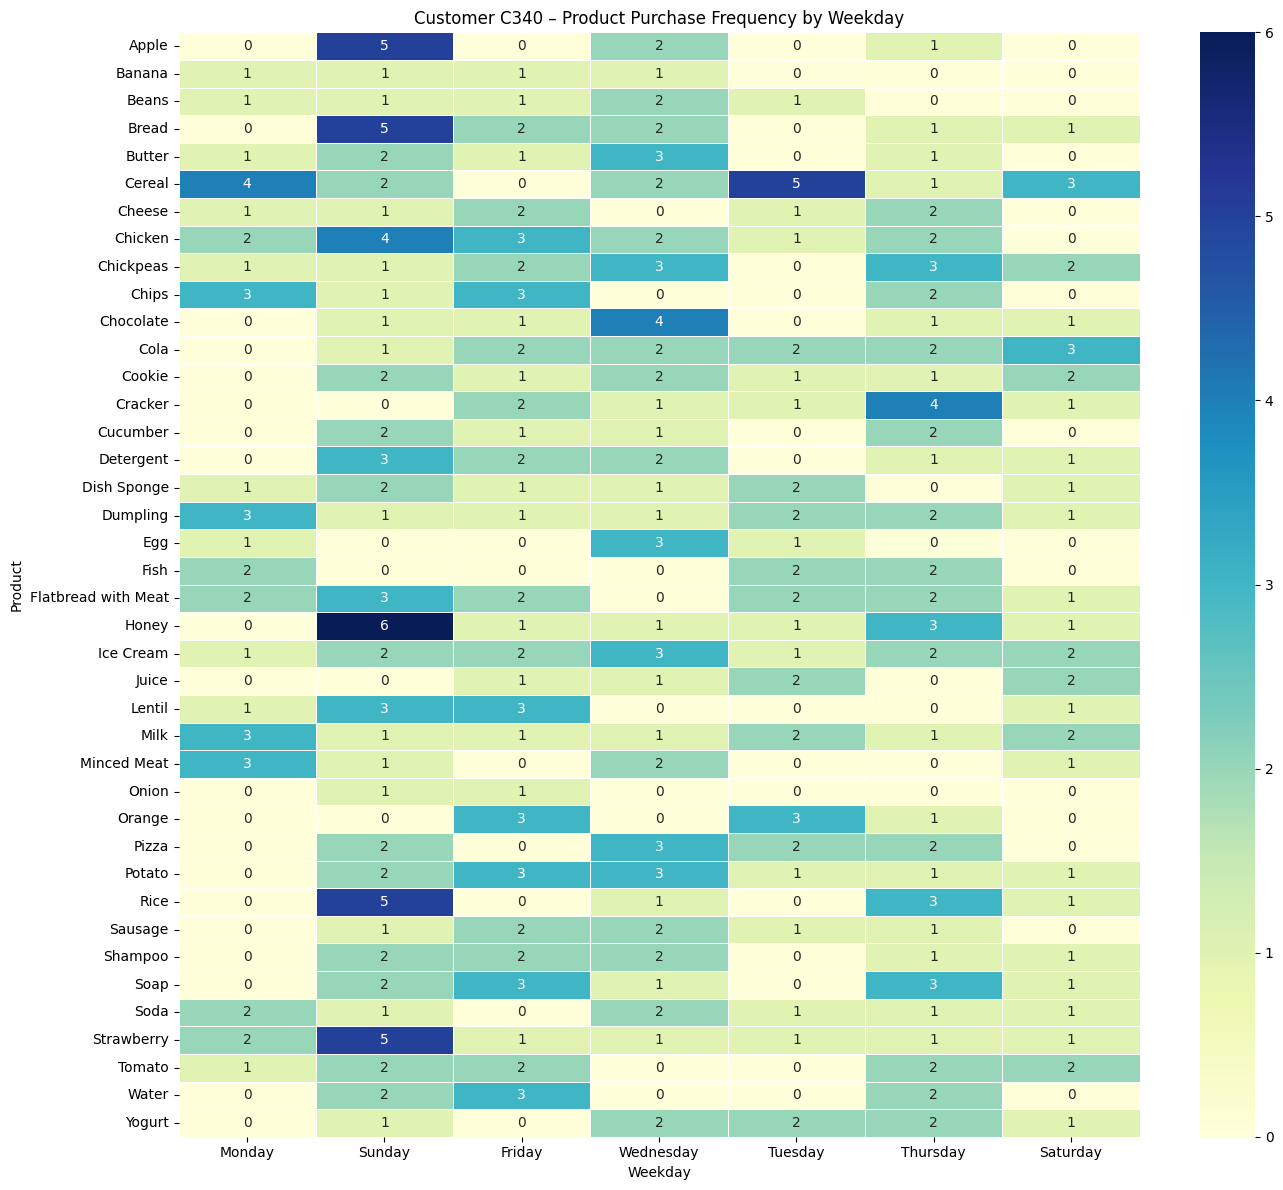

In [4]:
weekday_product_map = defaultdict(list)
for i, row in df_cust.iterrows():
    day = row['Weekday']
    for prod in row['ProductList']:
        weekday_product_map[day].append(prod)
weekday_summary = {
    day: Counter(products) for day, products in weekday_product_map.items()
}
all_days = list(weekday_summary.keys())
all_products = set(p for day in weekday_summary for p in weekday_summary[day])
heat_data = pd.DataFrame(0, index=sorted(all_products), columns=all_days)
for day in all_days:
    for prod, count in weekday_summary[day].items():
        heat_data.loc[prod, day] = count
plt.figure(figsize=(14, 12))
sns.heatmap(heat_data, cmap="YlGnBu", annot=True, fmt="d", linewidths=.5)
plt.title("Customer C340 – Product Purchase Frequency by Weekday")
plt.xlabel("Weekday")
plt.ylabel("Product")
plt.tight_layout()
plt.show()

In [5]:
pair_counter = Counter()
for products in df_cust['ProductList']:
    for pair in combinations(sorted(products), 2):
        pair_counter[pair] += 1
G = nx.Graph()
for (p1, p2), count in pair_counter.items():
    if count >= 2:
        G.add_edge(p1, p2, weight=count)
product_counts = Counter([item for sublist in df_cust['ProductList'] for item in sublist])
product_weekday = {}
for product in product_counts:
    days = df_cust[df_cust['ProductList'].apply(lambda x: product in x)]['Weekday']
    product_weekday[product] = days.value_counts().idxmax()
weekday_to_num = {
    'Monday': 1,
    'Tuesday': 2,
    'Wednesday': 3,
    'Thursday': 4,
    'Friday': 5,
    'Saturday': 6,
    'Sunday': 7
}
weekday_color_labels = {v: k for k, v in weekday_to_num.items()}
node_weekday_nums = [weekday_to_num.get(product_weekday.get(node, 'Monday'), 0) for node in G.nodes()]
node_sizes = [product_counts[node]*1.8 for node in G.nodes()]
node_labels = [
    f"<b>{node}</b><br>Count: {product_counts[node]}<br>Top Day: {product_weekday[node]}"
    for node in G.nodes()
]
pos = nx.spring_layout(G, k=0.7, iterations=100)
edge_x = []
edge_y = []
for edge in G.edges():
    x0, y0 = pos[edge[0]]
    x1, y1 = pos[edge[1]]
    edge_x += [x0, x1, None]
    edge_y += [y0, y1, None]
edge_trace = go.Scatter(
    x=edge_x,
    y=edge_y,
    line=dict(width=1, color='lightgrey'),
    hoverinfo='none',
    mode='lines'
)
node_x = []
node_y = []
for node in G.nodes():
    x, y = pos[node]
    node_x.append(x)
    node_y.append(y)

node_trace = go.Scatter(
    x=node_x,
    y=node_y,
    mode='markers+text',
    text=list(G.nodes()),
    textposition="top center",
    hoverinfo='text',
    hovertext=node_labels,
    marker=dict(
        showscale=True,
        colorscale='Jet',
        color=node_weekday_nums,
        size=node_sizes,
        colorbar=dict(
            thickness=15,
            title='Top Purchase Day',
            xanchor='left',
            titleside='right',
            tickvals=list(weekday_color_labels.keys()),
            ticktext=list(weekday_color_labels.values())
        ),
        line_width=2
    )
)

fig = go.Figure(data=[edge_trace, node_trace],
    layout=go.Layout(
        title=f"Customer {customer_id} Product Network – Top Purchase Day",
        titlefont_size=20,
        showlegend=False,
        hovermode='closest',
        margin=dict(b=20, l=5, r=5, t=60),
        annotations=[
            dict(
                text="Color = Most Frequent Purchase Day • Size = Product Frequency • Drag/Zoom = Enabled",
                showarrow=False,
                xref="paper", yref="paper",
                x=0.5, y=-0.1, xanchor='center', font=dict(size=14)
            )
        ],
        xaxis=dict(showgrid=False, zeroline=False),
        yaxis=dict(showgrid=False, zeroline=False)
    )
)

output_file = f"customer_{customer_id}_super_advanced_network.html"
fig.write_html(output_file)
IFrame(output_file, width="100%", height=600)

In [6]:
pair_counts = defaultdict(Counter)
for product_list in df_cust['ProductList']:
    for i in range(len(product_list) - 1):
        current_item = product_list[i]
        next_item = product_list[i+1]
        pair_counts[current_item][next_item] += 1

G = nx.DiGraph()

for src, targets in pair_counts.items():
    total = sum(targets.values())
    for tgt, count in targets.items():
        prob = round((count / total) * 100, 2)
        G.add_edge(src, tgt, weight=prob)

for src, targets in list(pair_counts.items()):
    for tgt in targets:
        if tgt not in pair_counts or src not in pair_counts[tgt]:
            # Add artificial reverse edge with half the original probability
            prob = round((pair_counts[src][tgt] / sum(pair_counts[src].values())) * 100, 2)
            G.add_edge(tgt, src, weight=round(prob * 0.5, 2))

pos = nx.spring_layout(G, k=0.8, iterations=100, seed=42)

edge_x = []
edge_y = []
edge_texts = []

for src, tgt, data in G.edges(data=True):
    x0, y0 = pos[src]
    x1, y1 = pos[tgt]
    edge_x += [x0, x1, None]
    edge_y += [y0, y1, None]
    edge_texts.append(f"{src} ➝ {tgt}<br>{data['weight']}%")

edge_trace = go.Scatter(
    x=edge_x,
    y=edge_y,
    line=dict(width=1.5, color='gray'),
    hoverinfo='text',
    mode='lines',
    text=edge_texts
)

node_x = []
node_y = []
node_colors = []
hover_texts = []

for node in G.nodes():
    x, y = pos[node]
    node_x.append(x)
    node_y.append(y)
    out_edges = G.out_edges(node)
    out_degree = len(out_edges)
    node_colors.append(out_degree)

    if out_edges:
        transitions = [
            f"{node} ➝ {target} ({G[node][target]['weight']}%)" for _, target in out_edges
        ]
        hover_text = "<br>".join(transitions)
    else:
        hover_text = f"{node} ➝ No outgoing"

    hover_texts.append(hover_text)

node_trace = go.Scatter(
    x=node_x,
    y=node_y,
    mode='markers+text',
    text=list(G.nodes()),
    textposition="top center",
    hoverinfo='text',
    hovertext=hover_texts,
    marker=dict(
        showscale=True,
        colorscale='YlGnBu',
        color=node_colors,
        size=22,
        colorbar=dict(
            thickness=15,
            title='No. of Next Products',
            xanchor='left',
            titleside='right'
        ),
        line=dict(width=2, color='DarkSlateGrey')
    )
)
fig = go.Figure(data=[edge_trace, node_trace],
    layout=go.Layout(
        title=f"🔁 Product Transition Network for Customer {customer_id}",
        titlefont_size=22,
        showlegend=False,
        hovermode='closest',
        margin=dict(b=20, l=5, r=5, t=60),
        annotations=[
            dict(
                text="Edge % = Transition Probability • Node Color = No. of Following Products",
                showarrow=False,
                xref="paper", yref="paper",
                x=0.5, y=-0.1, xanchor='center', font=dict(size=14)
            )
        ],
        xaxis=dict(showgrid=False, zeroline=False),
        yaxis=dict(showgrid=False, zeroline=False)
    )
)
fig.write_html(f"product_transition_bidirectional_{customer_id}.html")
IFrame("product_transition_bidirectional_C340.html", width="100%", height=900)

In [7]:
output_dir = f"sankey_weekday_{customer_id}"
os.makedirs(output_dir, exist_ok=True)

weekdays = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']

for weekday in weekdays:
    df_day = df_cust[df_cust['Weekday'] == weekday]
    if df_day.empty:
        continue
    pair_counts = defaultdict(Counter)
    for product_list in df_day['ProductList']:
        for i in range(len(product_list) - 1):
            src = product_list[i]
            tgt = product_list[i+1]
            pair_counts[src][tgt] += 1

    links = []
    for src, targets in pair_counts.items():
        total = sum(targets.values())
        for tgt, count in targets.items():
            prob = round((count / total) * 100, 2)
            links.append((src, tgt, prob))

    if not links:
        continue
    products = sorted(set([src for src, _, _ in links] + [tgt for _, tgt, _ in links]))
    product_to_idx = {prod: i for i, prod in enumerate(products)}

    source_indices = [product_to_idx[src] for src, tgt, prob in links]
    target_indices = [product_to_idx[tgt] for src, tgt, prob in links]
    values = [prob for _, _, prob in links]
    hover_texts = [f"{src} ➝ {tgt}<br>{prob}% on {weekday}" for src, tgt, prob in links]

    fig = go.Figure(data=[go.Sankey(
        node=dict(
            pad=20,
            thickness=20,
            line=dict(color="black", width=0.5),
            label=products,
            color="lightblue"
        ),
        link=dict(
            source=source_indices,
            target=target_indices,
            value=values,
            hovertemplate=hover_texts,
            color='rgba(255, 127, 14, 0.5)'
        )
    )])
    fig.update_layout(
        title_text=f"Product Flow on {weekday} – Customer {customer_id}",
        font=dict(size=13),
        margin=dict(l=10, r=10, t=40, b=10)
    )
    file_path = os.path.join(output_dir, f"sankey_{customer_id}_{weekday}.html")
    fig.write_html(file_path)

In [8]:
html = """
<div style="display: flex; overflow-x: auto; gap: 10px; padding: 10px;">
  <div style="min-width: 900px; flex-shrink: 0;">
    <p><b>Monday</b></p>
    <iframe src="sankey_weekday_C340/sankey_C340_Monday.html" width="900" height="600" style="border:1px solid #ccc;"></iframe>
  </div>
  <div style="min-width: 900px; flex-shrink: 0;">
    <p><b>Tuesday</b></p>
    <iframe src="sankey_weekday_C340/sankey_C340_Tuesday.html" width="900" height="600" style="border:1px solid #ccc;"></iframe>
  </div>
  <div style="min-width: 900px; flex-shrink: 0;">
    <p><b>Wednesday</b></p>
    <iframe src="sankey_weekday_C340/sankey_C340_Wednesday.html" width="900" height="600" style="border:1px solid #ccc;"></iframe>
  </div>
  <div style="min-width: 900px; flex-shrink: 0;">
    <p><b>Thursday</b></p>
    <iframe src="sankey_weekday_C340/sankey_C340_Thursday.html" width="900" height="600" style="border:1px solid #ccc;"></iframe>
  </div>
  <div style="min-width: 900px; flex-shrink: 0;">
    <p><b>Friday</b></p>
    <iframe src="sankey_weekday_C340/sankey_C340_Friday.html" width="900" height="600" style="border:1px solid #ccc;"></iframe>
  </div>
  <div style="min-width: 900px; flex-shrink: 0;">
    <p><b>Saturday</b></p>
    <iframe src="sankey_weekday_C340/sankey_C340_Saturday.html" width="900" height="600" style="border:1px solid #ccc;"></iframe>
  </div>
  <div style="min-width: 900px; flex-shrink: 0;">
    <p><b>Sunday</b></p>
    <iframe src="sankey_weekday_C340/sankey_C340_Sunday.html" width="900" height="600" style="border:1px solid #ccc;"></iframe>
  </div>
</div>
"""
HTML(html)